## first time setup
install packages and configure NLTK

In [1]:
import sys
# note: installing Kaleido on the fly seems not to work - make sure it is installed in the environment already
!{sys.executable} -m pip install pandas==1.3.5 numpy==1.24 nltk plotly ipywidgets #kaleido

In [2]:
import nltk
nltk.download('tagsets')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package tagsets to /home/jovyan/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## main script

### setup, data loading and filtering

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
import os
import numpy as np
import nltk
from nltk.data import load
tagdict = load('help/tagsets/upenn_tagset.pickle')
postaglist = list(tagdict.keys())

import json
import kaleido
import plotly.express as px
import plotly.graph_objects as go


In [4]:
def load_dataframes(base_dir):
    dfs = []
    for f in os.listdir(base_dir):
        df = pd.read_pickle(f"{base_dir}/{f}")

        dfs.append(df)

    dataset = pd.concat(dfs)
    
    return dataset

In [5]:
def load_predefined_queries(jsonfile):
    
    f = open (jsonfile, "r")
    compdata = json.load(f)
    
    queries = {}
    
    for t in compdata["description"]["tasks"]:
        name = t["name"]
        querystr = ""
        for h in t["hints"]:
            if h["type"]=="TextHint":
                querystr = h["text"]
        queries[name] = querystr
    
    return queries
    

In [6]:
def reformat_value(x):
    txt = x["value"]
    
    prefixes = ["CLIP: ","Temporal CLIP: "]
    
    for p in prefixes:
        if txt.startswith(p):
            txt = txt[len(p):]
            
    # strip leading and trailing whitespace
    txt = txt.strip()
    
    # remove > 
    txt = txt.replace('>', '')
    
    # remove any double spaces 
    txt = txt.replace('  ', ' ')
    
    x["value"] = txt
    return x

In [7]:
dataset = load_dataframes("/data/vbse2022/data/dataframes/vbse2022_logs_dataframes/vbse2022")
dataset.shape

(31837679, 16)

In [8]:
predefinedqueries = load_predefined_queries("/data/vbse2022/data/DRES data/VBS Extended Test Nov 11, 2022.json")
print(predefinedqueries)

{'t1': 'A snowboarder falling', 't2': 'Bride walking and dancing', 'vbse001': 'A woman holding a steaming mug close to the camera.', 'vbse002': 'Viewer moving fast backwards on railway tracks.', 'vbse003': 'Close-up shot of water waves reflecting the sun.', 'vbse004': 'A woman having a mobile phone call in bed', 'vbse005': 'A red seaplane on a lake with forests around.', 'vbse006': 'Woman in yellow shirt standing in a room with a yellow sofa.', 'vbse007': 'Four people waving on a mountain summit.', 'vbse008': 'A white van driving between ruins.', 'vbse009': 'Two men running backwards up a downwards moving escalator.', 'vbse010': 'People dancing and drumming on the street at night.', 'vbse011': 'Three man and a woman riding on a covered boat.', 'vbse012': 'View of a volcano with clouds moving in from the right.', 'vbse013': 'Flashing shots of a man on a bed and in front of a wall.', 'vbse014': 'A white dress is waving in the wind over the floor.', 'vbse015': 'A man lighting at a piano w

In [9]:
textqueries = dataset.loc[dataset["category"]=="TEXT"]
# from VISIONE, keep only the ones with type jointEmbedding
textqueries = textqueries.loc[np.logical_or(np.logical_not(textqueries["team"].str.contains("visione")),textqueries["type"]=="jointEmbedding")]
textqueries.shape

(2887, 16)

In [10]:
# reformat values
textqueries = textqueries.apply(reformat_value, axis=1)

### Query change events
- check if initial query changed
- add delta length of queries in characters

In [11]:
querychanges = pd.DataFrame(columns=list(textqueries.columns.values)+["len","delta_len"])


for task in textqueries["task"].unique():
    queries_ta = textqueries.loc[textqueries["task"]==task]
    for team in queries_ta["team"].unique():
        queries_ta_te = queries_ta.loc[queries_ta["team"]==team]
        queries_ta_te = queries_ta_te.sort_values(by=['elapsed_since_task_start_ms'])
        
        # check if query is different from previous (and first from predefined), otherwise skip
        prev_query = predefinedqueries[task]
        prev_query_len = len(prev_query)
            
        for idx in range(0,queries_ta_te.shape[0]):
            
            if queries_ta_te.iloc[idx]["value"] != prev_query:
                qlen = len(queries_ta_te.iloc[idx]["value"])
                
                row = queries_ta_te.iloc[idx]
                row["len"] = qlen
                row["delta_len"] = qlen-prev_query_len
            
                querychanges = querychanges.append(row,ignore_index=True)

                prev_query = queries_ta_te.iloc[idx]["value"]
                prev_query_len = len(prev_query)

            
#print(querychanges)

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


### POS taggging
a simplified POS tags set is used
- POS tagging of predefined queries
- differences in POS tags for first query change after 45s, and final query
- differences in POS tags for queries modified in first 45s

In [12]:
def simplify_tag_list(tl):
    
    stl = {}
    
    for t in tl:
        stl[t] = t
    
    stl["."] = "punctuation, symbol"
    stl[","] = "punctuation, symbol"
    stl[":"] = "punctuation, symbol"
    stl["--"] = "punctuation, symbol"
    stl["``"] = "punctuation, symbol"
    stl["''"] = "punctuation, symbol"
    stl["("] = "punctuation, symbol"
    stl[")"] = "punctuation, symbol"
    stl["$"] = "punctuation, symbol"
    stl["SYM"] = "punctuation, symbol"
    stl["LS"] = "punctuation, symbol"
    stl["POS"] = "punctuation, symbol"
    
    stl["VB"] = "verb"
    stl["VBN"] = "verb"
    stl["VBG"] = "verb"
    stl["VBZ"] = "verb"
    stl["VBD"] = "verb"
    stl["VBP"] = "verb"
    stl["MD"] = "verb"

    stl["JJ"] = "adjective, numeral"
    stl["JJR"] = "adjective, numeral"
    stl["JJS"] = "adjective, numeral"
    stl["CD"] = "adjective, numeral"

    stl["NN"] = "noun"
    stl["NNP"] = "noun"
    stl["NNS"] = "noun"
    stl["NNPS"] = "noun"

    stl["RB"] = "adverb"
    stl["RBR"] = "adverb"
    stl["RBS"] = "adverb"
    stl["WRB"] = "adverb"

    stl["PRP"] = "pronoun"
    stl["PRP$"] = "pronoun"
    stl["WP"] = "pronoun"
    stl["WP$"] = "pronoun"

    stl["CC"] = "conjunction"
    stl["IN"] = "conjunction"
    stl["EX"] = "conjunction"

    stl["RP"] = "particle"
    stl["TO"] = "particle"

    stl["DT"] = "(pre-)determiner"
    stl["PDT"] = "(pre-)determiner"
    stl["WDT"] = "(pre-)determiner"
  
    stl["FW"] = "other"
    stl["UH"] = "other"

    return stl

In [13]:
def pos_stats(query,tagmap,stl):
        
    ptrow = pd.Series(np.zeros((len(stl),)),index=stl)
        
    tok = nltk.tokenize.word_tokenize(query)
    ptags = nltk.pos_tag(tok)
    
    for ptpair in ptags:
               
        ptrow[tagmap[ptpair[1]]] += 1
        
    return ptrow
        

In [14]:
simple_tag_map = simplify_tag_list(postaglist)
s_postaglist = list(set(simple_tag_map.values()))

colnames = ["query"]+s_postaglist
predef_pos = pd.DataFrame(columns=colnames)

for q in predefinedqueries.keys():
  
    # skip tests and unused
    if (q=="t1") or (q=="t2"):
        continue
    if (q=="vbse007") or (q=="vbse011") or (q=="vbse027"):
        continue
    
    
    psrow = pos_stats(predefinedqueries[q],simple_tag_map,s_postaglist)

    predef_pos = predef_pos.append(pd.Series([q]+psrow.tolist(), index=colnames), ignore_index=True)  


In [15]:
def get_pos_diff_stats(querychanges,simple_tag_map,s_postaglist,mode):
    
    colnames = ["team","task","pos_type","count"]
    qdstats = pd.DataFrame(columns=colnames)

    if mode=="firstmod":
        querychanges_f = querychanges.loc[querychanges["elapsed_since_task_start_ms"]>45000]
    elif mode=="last":
        querychanges_f = querychanges.loc[querychanges["elapsed_since_task_start_ms"]>45000]
    elif mode=="within45":
        querychanges_f = querychanges.loc[querychanges["elapsed_since_task_start_ms"]<=45000]
    else:
        print("unknown mode "+mode)
        return

    for task in querychanges_f["task"].unique():
        queries_ta = querychanges_f.loc[querychanges_f["task"]==task]

        predef_row = pos_stats(predefinedqueries[task],simple_tag_map,s_postaglist)

        for team in queries_ta["team"].unique():
            queries_ta_te = queries_ta.loc[queries_ta["team"]==team]

            if mode=="firstmod":
                queries_ta_te = queries_ta_te.sort_values(by=['elapsed_since_task_start_ms'])
            elif mode=="last":
                queries_ta_te = queries_ta_te.sort_values(by=['elapsed_since_task_start_ms'],ascending=False)
            elif mode=="wihtin45":
                queries_ta_te = queries_ta_te.sort_values(by=['elapsed_since_task_start_ms'])

            psrow = pos_stats(queries_ta_te.iloc[0]["value"],simple_tag_map,s_postaglist)

            for p in s_postaglist:
                psrow[p] = psrow[p] - predef_row[p]

                qdstats = qdstats.append(pd.Series([team[:-1],task,p,psrow[p]], index=colnames), ignore_index=True) 

    qdstats = qdstats.sort_values(by=['pos_type'])
    
    return qdstats
 

In [16]:
# get first query per task and team after 45s
first_mod_query = get_pos_diff_stats(querychanges,simple_tag_map,s_postaglist,"firstmod")
last_query = get_pos_diff_stats(querychanges,simple_tag_map,s_postaglist,"last")
initial_query = get_pos_diff_stats(querychanges,simple_tag_map,s_postaglist,"within45")

### Plotting
- scatter plot of query change times (per task, per team)
- plot of changes of query length (per user)
- POS stats of predefined queries
- differences in POS stats

In [25]:
def calc_scatter_coords(row,tasknames):
    row["task_index"] = tasknames.index(row["task"])
    row["sec"] = row["elapsed_since_task_start_ms"]/1000
    row["secsubm"] = row["correct_submission_time_ms"]/1000
    row["entrytype"] = "query"+row["team"][-1]
    row["entrysubm"] = "submission"+row["team"][-1]
    row["baseteam"] = row["team"][:-1]
    
    return row
    

def scatterplot_times_per_task_team(plotdata):

    scatterdata = plotdata
    tasknames = list(scatterdata["task"].unique())
    tasknames.sort()
    
    scatterdata = scatterdata.apply(lambda x: calc_scatter_coords(x,tasknames), axis=1)
    
    # copy entries that have a submission row
    submdata = scatterdata.loc[np.logical_not(np.isnan(scatterdata["secsubm"]))]
    submdata["entrytype"] = submdata["entrysubm"]
    submdata["sec"] = submdata["secsubm"]
    
    scatterdata = scatterdata.append(submdata)
    
    fig = px.scatter(scatterdata, x="sec", y="task_index",color="baseteam",symbol="entrytype",
                    symbol_sequence= ["circle", "diamond","triangle-up","triangle-down","circle-open","diamond-open","triangle-up-open","triangle-down-open"],
                    labels={
                     "sec": "Time from task start [s]",
                     "task_index": "Task",
                     "team": "Team"
                     },
                     height = 1000,
                     width = 1600,
                     title="Times of query changes and submission per task and team",
                     )

    fig.update_layout(
        yaxis = dict(
            tickmode = 'array',
            tickvals = list(range(len(tasknames))),
            ticktext = tasknames,
        )
    )
    
    fig.write_image("query_changes_submission.pdf",engine='kaleido')
    fig.show()


In [46]:
def plot_query_length(plotdata,mean_ql):
      
    lenplotdata = plotdata
    tasknames = list(lenplotdata["task"].unique())
    tasknames.sort()
    
    lenplotdata = lenplotdata.apply(lambda x: calc_scatter_coords(x,tasknames), axis=1)
    
    queryperteam = list(lenplotdata["team"].unique())
    queryperteam.sort()   
    
    # sample mean length per team every second
    colnames = ['sec','delta_len','team','baseteam']
    len_accum = pd.DataFrame(columns=colnames)

    
    for qpt in queryperteam:
        len_qpt = lenplotdata.loc[lenplotdata["team"]==qpt]
        
        datarow = [0,0,len_qpt.iloc[0]["team"],len_qpt.iloc[0]["baseteam"]]
        
        len_accum = len_accum.append(pd.Series(datarow, index=colnames), ignore_index=True)
        
        for s in range(1,301):
            len_qpt_s = len_qpt.loc[np.logical_and(len_qpt["sec"]>=s-1,len_qpt["sec"]>s)]
            
            mean_len = len_qpt_s["len"].mean()
            
            datarow[0] = s
            datarow[1] = mean_len-mean_ql

        
            len_accum = len_accum.append(pd.Series(datarow, index=colnames), ignore_index=True)  
  
    
    # reverse color list to match other plots
    mycolors = px.colors.qualitative.Plotly[:3]
    mycolors.reverse()
    
    fig = px.line(len_accum, x="sec", y="delta_len", 
                    labels={
                     "sec": "Time from task start [s]",
                     "delta_len": "Diff. length [characters]",
                     "team": "Team"
                     },
                     title='Mean query length difference to mean start query length',color="baseteam",symbol="team",
                     height = 1000,
                     width = 1600,
                     color_discrete_sequence=mycolors
                 )
    fig.write_image("query_length_diff.pdf",engine='kaleido')
    fig.show() 

   

/tmp/ipykernel_452/1796710761.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_452/1796710761.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



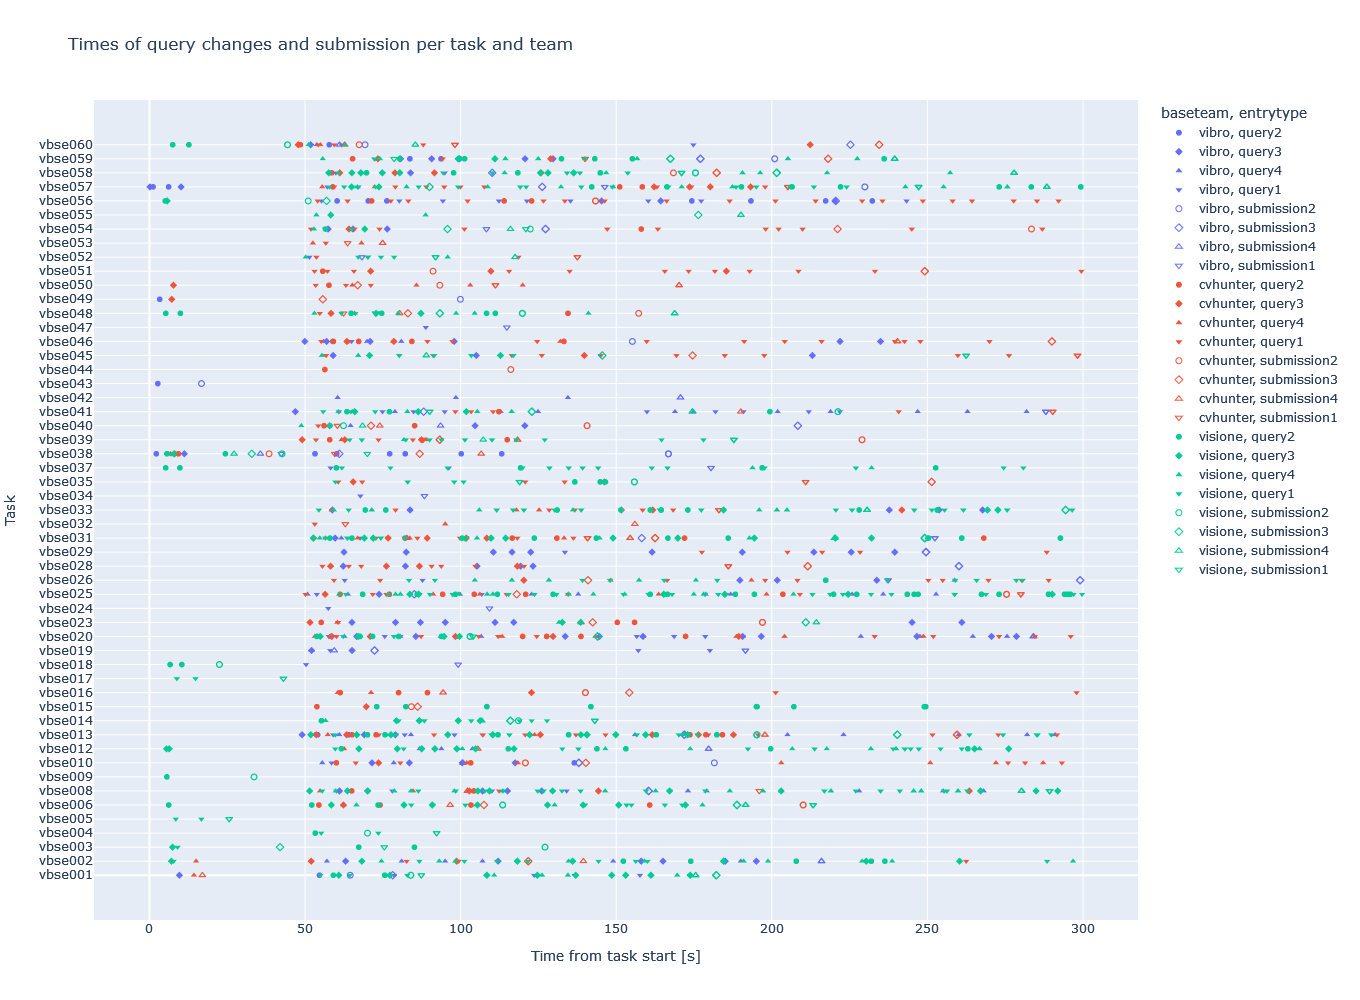

In [26]:
scatterplot_times_per_task_team(querychanges)

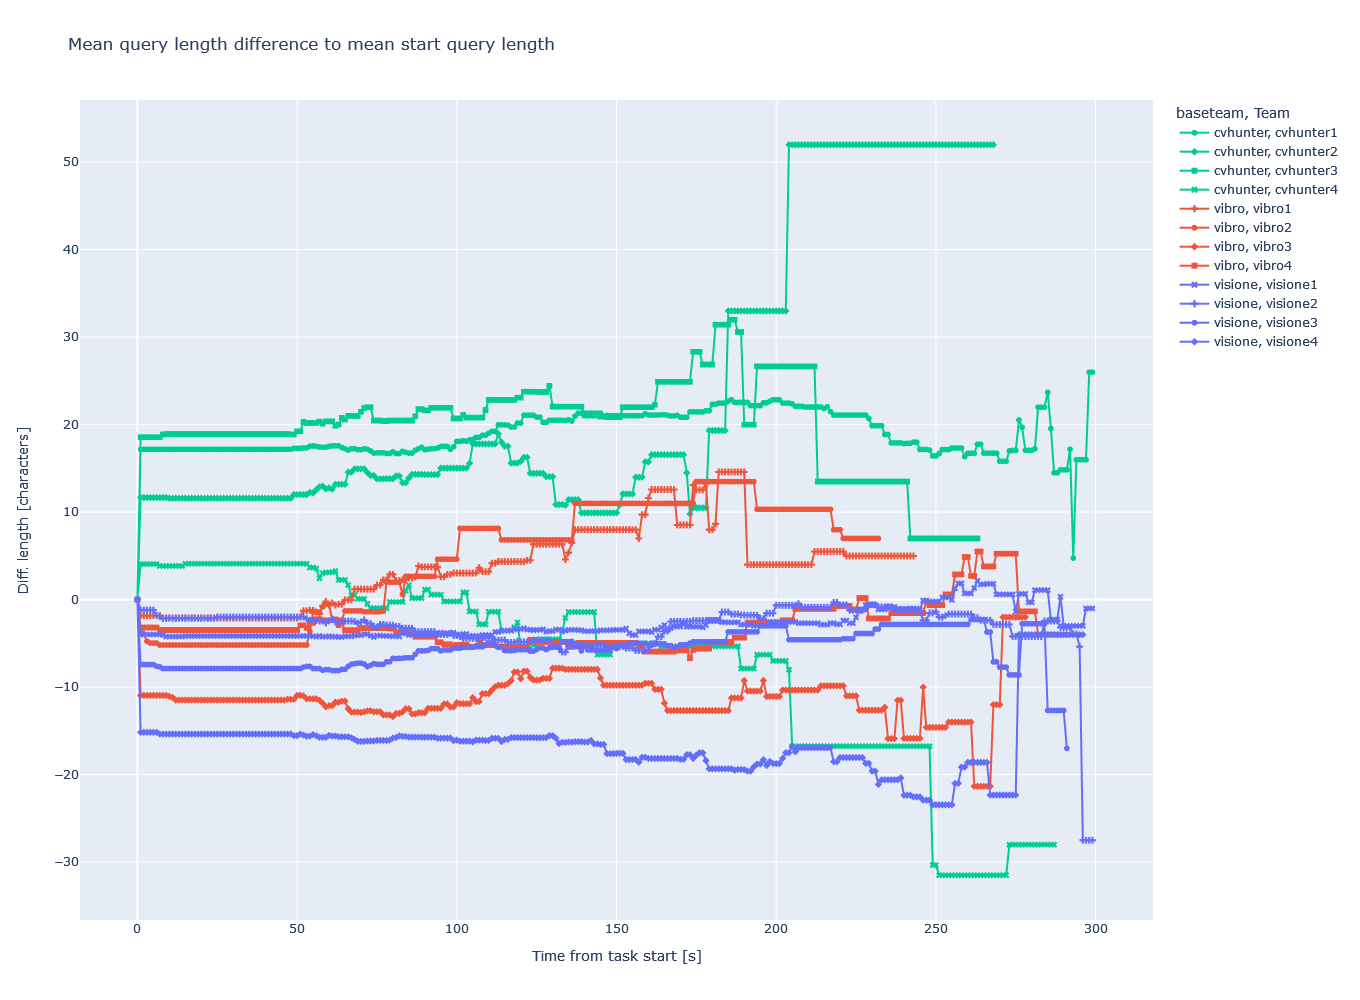

In [47]:
# get mean start query length
mean_ql = float(sum([len(ele) for ele in list(predefinedqueries.values())])) / len(predefinedqueries.keys())
plot_query_length(querychanges,mean_ql)

In [31]:
def plot_pos_stats(posstats,postaglist):
    
    # remove tags without counts
    psfiltered = posstats.loc[:, (posstats != 0).any(axis=0)]
    pslistfiltered = psfiltered.columns[1:]
    
    # sort by most common tags
    s = psfiltered.sum()
    psfiltered = psfiltered[s[1:].sort_values(ascending=False).index]#
    pslistfiltered = psfiltered.columns
    psfiltered["query"] = posstats["query"]
        
    fig = px.bar(psfiltered, x="query", y=pslistfiltered, title="POS tag statistics for predefined queries",
                 height=670,width=1600)#,color_discrete_sequence=px.colors.qualitative.Light24)
    
    fig.write_image("pos_tags_predefined.pdf",engine='kaleido')
    fig.show()

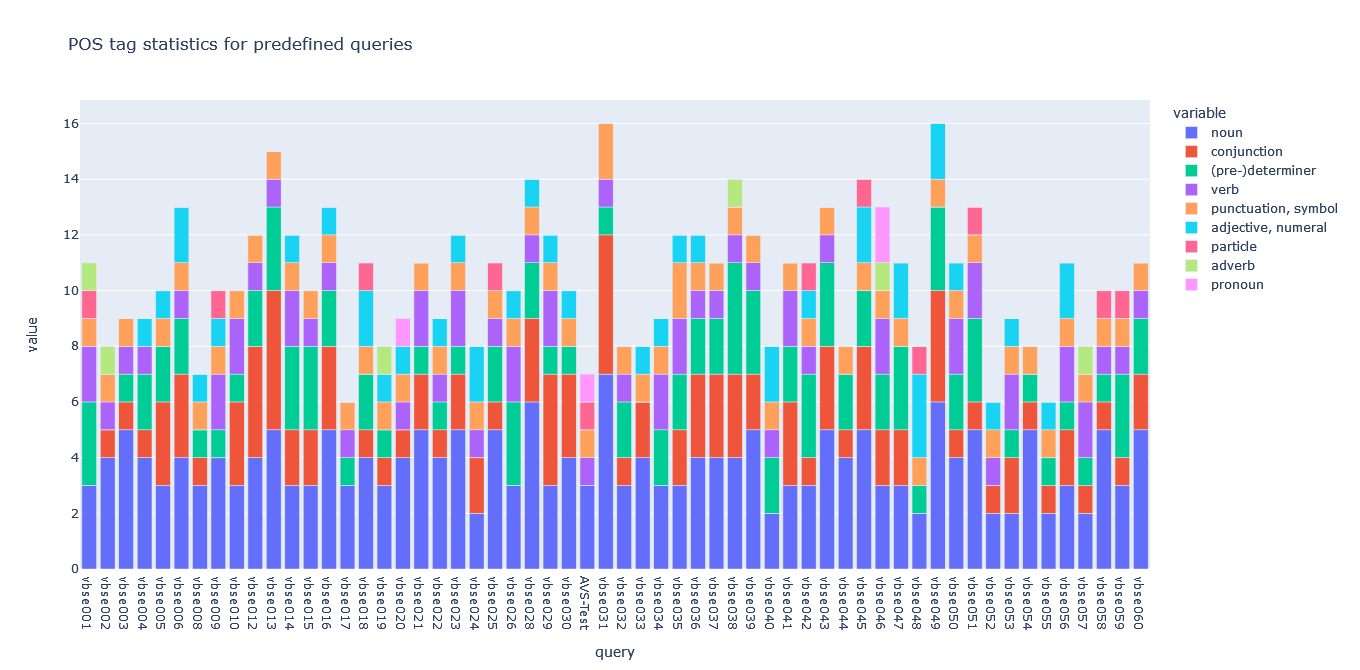

In [32]:
plot_pos_stats(predef_pos,s_postaglist)

In [41]:
def boxplot_pos_diff(qlist,title,file_suffix):
    fig = px.box(qlist, x="pos_type", y="count",color="team",height=600,width=1200,title=title)
    
    fig.write_image("pos_diff"+file_suffix+".pdf",engine='kaleido')
    fig.show()

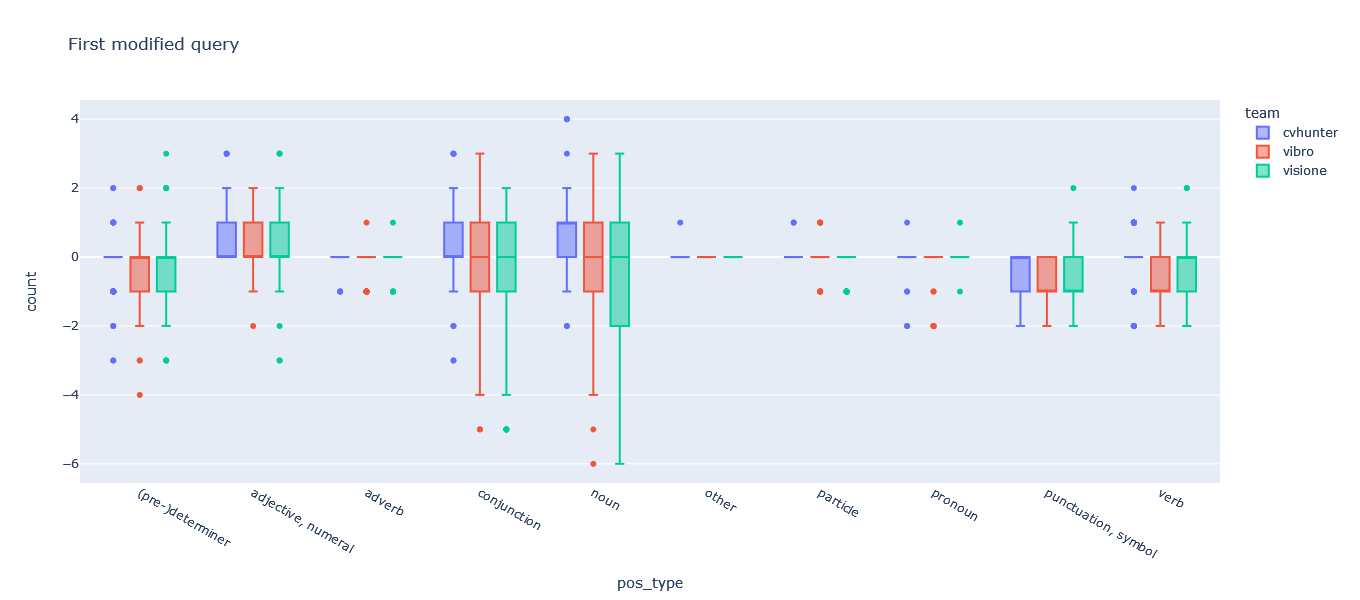

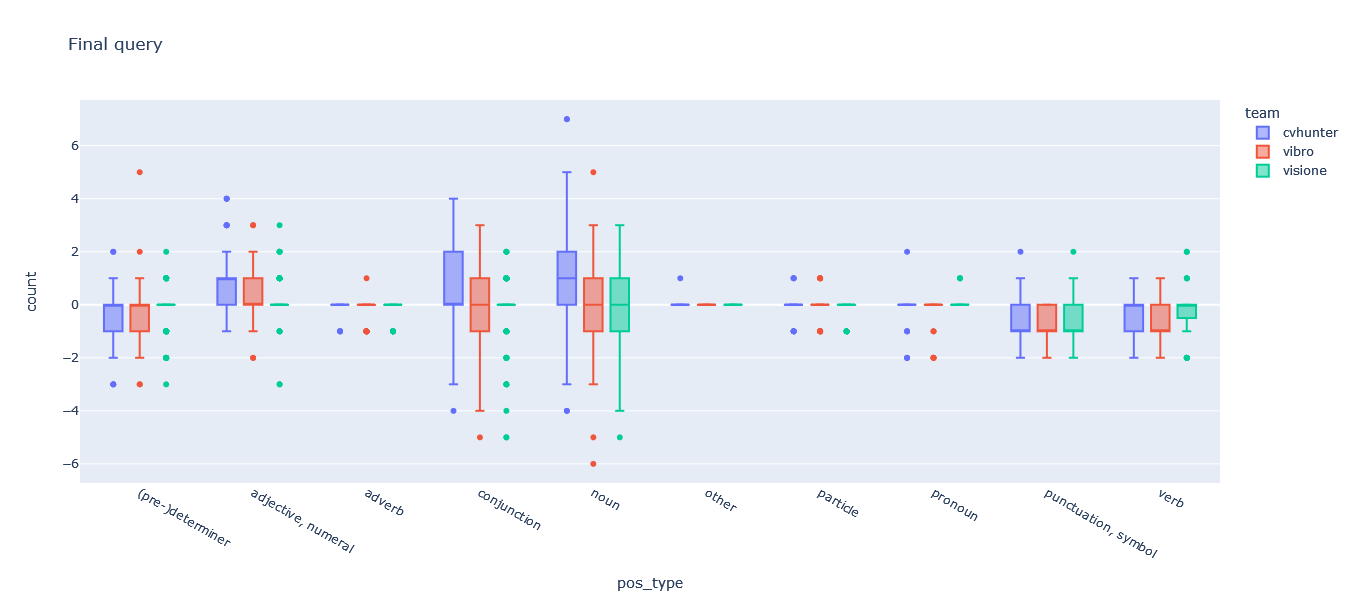

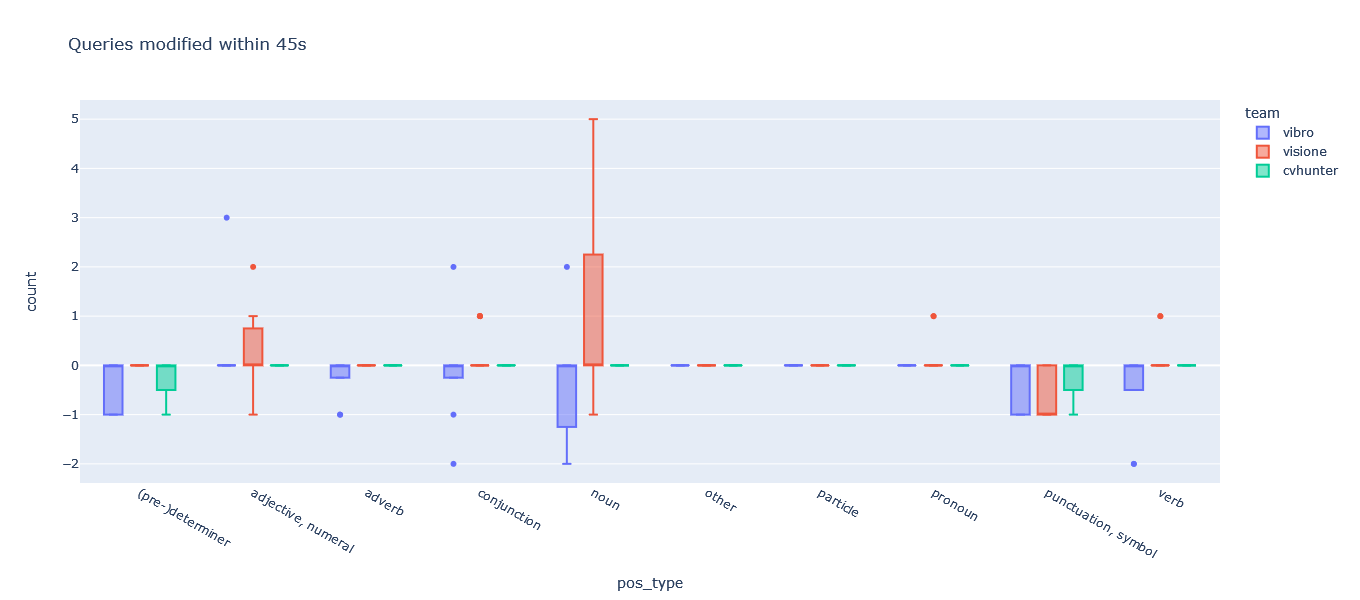

In [42]:
boxplot_pos_diff(first_mod_query,"First modified query","first_mod_query")
boxplot_pos_diff(last_query,"Final query","last_query")
boxplot_pos_diff(initial_query,"Queries modified within 45s","within45")